**Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp) 

# Group3 Final Project: Segmentation of ISPRS Vaihingen dataset with DSM data

This U-net file is one of the two final program files.
(The other one is for Deeplab3+)

Group member: Yu-Chuan Cheng 4998248

## Mount Google Drive to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks/Deep learning task

/content/drive/MyDrive/Colab Notebooks/Deep learning task


## Check the GPU

In [ ]:
!nvidia-smi

Sun Sep 18 11:41:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import packages

In [ ]:
!pip install -U git+https://github.com/albu/albumentations
!pip install git+https://github.com/qubvel/segmentation_models
!pip uninstall opencv-python-headless -y
!pip install opencv-python-headless==4.1.2.30
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-g6jn2cdn
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-g6jn2cdn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-i5e2yrmd
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-i5e2yrmd
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 1.5 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=a56f16ae0ea13faa41baf0cab3fba3da01d613418a134068d4a4bd27ac7a86a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-rem7o0xu/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, concatenate, Concatenate
from tensorflow.keras.layers import AveragePooling2D, ReLU, UpSampling2D, Normalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.metrics import OneHotMeanIoU, OneHotIoU

import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import tensorflow.keras.backend as K
# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
# Operation with arrays
import numpy as np
# Paths and files
from os.path import join,basename,splitext
import os
from glob import glob
from natsort import natsorted
# Reading images
import tifffile
from PIL import Image
# Others
import random

from sklearn import decomposition, preprocessing

## Dataset

We will work with the ISPRS [2D Semantic Labeling benchmark - Vaihingen](https://www.isprs.org/education/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx).

The dataset contains 33 patches (of different sizes), each consisting of a true orthophoto (TOP), extracted from a larger TOP mosaic, and a Digital Surface Model (DSM).

<center>
<img width=500 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/overview_tiles.jpg?width=398.4830805134189&height=500" img>
</center>

Labelled ground truth is provided for all areas. An example of a patch from the dataset, where a) true orthophoto, b) DSM, and c) ground truth.

<center>
<img width=600 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/examples_top_dsm_gts.png?width=500&height=196.7930029154519" img>
</center>


### Loading the data

To create the train, validation and test sets, we will follow the benchmark guidelines:

<center>
<img width=600 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/table_label_contest_image_overview.png?width=500&height=397.5490196078431" img>
</center>

So, the areas for training and testing are the following:

|  Set  |   Areas   |
|-------|-----------|
| Train | 1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37 |
| Test  | 2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38 |

The folder structure is the following:

- _dsm_: Digital Surface Models with information about the height of each geographical area.
- _gts_: Ground Truths or References with information about the semantic class of each pixel.
- _top_: True Orthophoto with a False RGB Color composition with near infrared, red and green bands.

Reading all images from the _top_, _dsm_ and _gts_ folders

In [ ]:
# Path to the dataset folder in Google Drive
root_path = "ISPRS_semantic_labeling_Vaihingen"
path_top = join(root_path,"top")
path_dsm = join(root_path,"dsm")
path_gts = join(root_path,"gts")

# List with all TIF images in each folder
list_top = glob(join(path_top,"*.tif"))
list_top = natsorted(list_top, key=lambda y: y.lower())

list_dsm = glob(join(path_dsm,"*.tif"))
list_dsm = natsorted(list_dsm, key=lambda y: y.lower())

list_gts = glob(join(path_gts,"*.tif"))
list_gts = natsorted(list_gts, key=lambda y: y.lower())

### Train, Validation and Test
Let's create the train, validation and test sets

In [ ]:
# Images IDs for train and test
train_ids = [1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37]
test_ids = [2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38]

list_top_train, list_top_val, list_top_test = ([] for i in range(3))
list_dsm_train, list_dsm_val, list_dsm_test = ([] for i in range(3))
list_gts_train, list_gts_val, list_gts_test = ([] for i in range(3))

In [ ]:
for top,dsm,gts in zip(list_top,list_dsm,list_gts):
  # Get the aread ID from the filename
  area_id = int(splitext(basename(top))[0].split("area")[-1])
  # Train set
  if area_id in train_ids:    
    list_top_train.append(top)
    list_dsm_train.append(dsm)
    list_gts_train.append(gts)
  # Test set
  elif area_id in test_ids:    
    list_top_test.append(top)
    list_dsm_test.append(dsm)
    list_gts_test.append(gts)

# shuffle train lists
temp = list(zip(list_top_train,list_dsm_train,list_gts_train))
random.seed(10)
random.shuffle(temp)
list_top_train,list_dsm_train,list_gts_train = zip(*temp)

# take 25% as validation set
p_val = 0.25
n_val = int(p_val*len(list_top_train))

list_top_val = list_top_train[:n_val]
list_top_train = list_top_train[n_val:]

list_dsm_val = list_dsm_train[:n_val]
list_dsm_train = list_dsm_train[n_val:]

list_gts_val = list_gts_train[:n_val]
list_gts_train = list_gts_train[n_val:]

### Dataset information

In [ ]:
def print_info(list_top,list_dsm,list_gts):
  for top,dsm,gts in zip(list_top,list_dsm,list_gts):
    gt_temp = tifffile.imread(gts)
    n_classes = len(np.unique(gt_temp.reshape(gt_temp.shape[0]*gt_temp.shape[1],-1),axis=0))
    print("TOP:{} , DSM:{} , GT:{} , N:{}".format(basename(top),
                                  basename(dsm),
                                  basename(gts),
                                  n_classes))

Let's see the number of classes in each image. 

**It is very important that all sets have samples of all classes.**

In [ ]:
# Train
print("Train:")
print_info(list_top_train,list_dsm_train,list_gts_train)

# Validation
print("\nValidation:")
print_info(list_top_val,list_dsm_val,list_gts_val)

# Test
print("\nTest:")
print_info(list_top_test,list_dsm_test,list_gts_test)

Train:
TOP:top_mosaic_09cm_area28.tif , DSM:dsm_09cm_matching_area28.tif , GT:top_mosaic_09cm_area28.tif , N:6
TOP:top_mosaic_09cm_area37.tif , DSM:dsm_09cm_matching_area37.tif , GT:top_mosaic_09cm_area37.tif , N:5
TOP:top_mosaic_09cm_area13.tif , DSM:dsm_09cm_matching_area13.tif , GT:top_mosaic_09cm_area13.tif , N:5
TOP:top_mosaic_09cm_area11.tif , DSM:dsm_09cm_matching_area11.tif , GT:top_mosaic_09cm_area11.tif , N:5
TOP:top_mosaic_09cm_area30.tif , DSM:dsm_09cm_matching_area30.tif , GT:top_mosaic_09cm_area30.tif , N:5
TOP:top_mosaic_09cm_area32.tif , DSM:dsm_09cm_matching_area32.tif , GT:top_mosaic_09cm_area32.tif , N:6
TOP:top_mosaic_09cm_area7.tif , DSM:dsm_09cm_matching_area7.tif , GT:top_mosaic_09cm_area7.tif , N:5
TOP:top_mosaic_09cm_area1.tif , DSM:dsm_09cm_matching_area1.tif , GT:top_mosaic_09cm_area1.tif , N:6
TOP:top_mosaic_09cm_area23.tif , DSM:dsm_09cm_matching_area23.tif , GT:top_mosaic_09cm_area23.tif , N:6
TOP:top_mosaic_09cm_area17.tif , DSM:dsm_09cm_matching_area17.t

### Visualization of dataset samples

Image: ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area23.tif


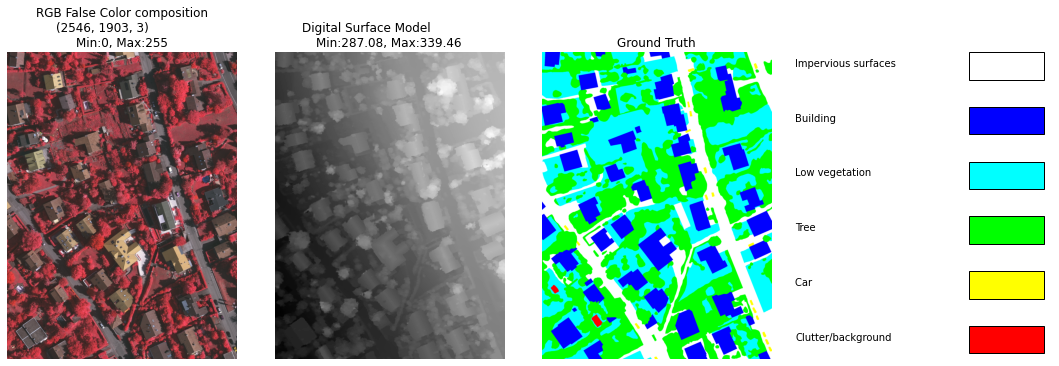

In [ ]:
#@title Samples Visualization { run: "auto"}
#@markdown Select a sample
id_sample = 19 #@param {type:"slider", min:0, max:32, step:1}
img_top = tifffile.imread(list_top[id_sample])
img_dsm = tifffile.imread(list_dsm[id_sample])

print("Image: {}".format(list_top[id_sample]))

plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.imshow(img_top)
plt.title("RGB False Color composition\n{}\
          \nMin:{}, Max:{}".format(img_top.shape,
                                     img_top.min(),
                                     img_top.max()))
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_dsm, cmap="gray")
plt.title("Digital Surface Model\
            \nMin:{:.2f}, Max:{:.2f}".format(img_dsm.min(),
                                             img_dsm.max()))
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(tifffile.imread(list_gts[id_sample]))
plt.title("Ground Truth")
plt.axis("off")

g = plt.subplot(1,4,4)
g.axes.set_xlim(0,3.4)
g.axes.set_ylim(-0.01,0.55)

g.text(0, 0.025, "Clutter/background")
g.text(0, 0.125, "Car ")
g.text(0, 0.225, "Tree ")
g.text(0, 0.325, "Low vegetation")
g.text(0, 0.425, "Building ")
g.text(0, 0.525, "Impervious surfaces")

x_rec = 2.3
g.add_patch(patches.Rectangle((x_rec,0.0), 1, 0.05, facecolor="#FF0000", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.1), 1, 0.05, facecolor="#FFFF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.2), 1, 0.05, facecolor="#00FF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.3), 1, 0.05, facecolor="#00FFFF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.4), 1, 0.05, facecolor="#0000FF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.5), 1, 0.05, facecolor="#FFFFFF", edgecolor="black"))
g.axis("off")

plt.tight_layout()
plt.show()

### Classes
Dictionary to represent each color and its corresponding class.

In [ ]:
color2index = {(255,255,255) : 0,
               (0  ,0  ,255) : 1,
               (0  ,255,255) : 2,
               (0  ,255,0  ) : 3,
               (255,255,0  ) : 4,
               (255,0  ,0  ) : 5
               }
n_classes = len(color2index)

## Data Generator

Requirements of the model:

- **Input:** Image $[height×width×bands]$
- **Output:** Image $[height×width×classes]$

As the images are too big, we will extract patches with a size $[p×p]$ and step (stride) $s$.

<center>
<img src="https://drive.google.com/uc?export=view&id=1UYrpG-sD_UGCRR7Ras73THF-sbqQoGTu" width=100 img>
</center>


Data Generator parameters:
- _batch_size_: number of samples per batch
- _patch_size_: size of the patch extracted from the image
- _step_size_: step to extract patches from the image
- _list_top_: list with paths of RGB images
- _list_dsm_: list with paths of DSM images
- _list_gts_: list with paths of GT images
- _n_classes_: number of classes
- _colormap_gt_: dictionary with the colormap to convert RGB image $[H×W×3]$ to label image $[H×W×1]$



In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self,
               batch_size,
               patch_size,
               step_size,
               list_top,                
               list_gts,
               list_dsm,
               n_classes,
               colormap_gt=None,
               augmentation=None,
               preprocessing=None,               
               shuffle=True):
    self.batch_size = batch_size
    self.patch_size = patch_size
    self.step_size = step_size
    self.list_top = list_top    
    self.list_gts = list_gts
    self.list_dsm = list_dsm
    self.n_classes = n_classes
    self.colormap_gt = colormap_gt
    self.augmentation = augmentation
    self.preprocessing = preprocessing        
    self.shuffle= shuffle
    self.path_coords = self.__get_path_coords()
    self.n_patchs = len(self.path_coords)

  def __get_path_coords(self):
    path_coords = []    
    for path_image, path_label, path_dsm in zip(self.list_top,self.list_gts,self.list_dsm):       
      width, height = Image.open(path_label).size      
      for y in range(0, height, self.step_size):
        for x in range(0, width, self.step_size):
          if (x + self.patch_size) > width:
            x = width - self.patch_size
          if (y + self.patch_size) > height:
            y = height - self.patch_size
          
          path_coords.append((path_image, path_label, (x,y), path_dsm))          
    return path_coords
        
  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.path_coords)

  def __len__(self):
    return np.ceil(self.n_patchs/self.batch_size).astype("int")

  def __get_patch_image(self, path_image, x, y):
    # Reading the RGB image
    data_image = Image.open(path_image)
    data_image = data_image.crop((x, y, 
                                  x + self.patch_size, y + self.patch_size))
    data_image = np.asarray(data_image).astype("float32")
    
    # return data_image/255.0
    return data_image

  def __get_patch_mask(self, path, x, y):
    # Reading the mask
    data_mask = Image.open(path)
    data_mask = data_mask.crop((x, y, 
                                x + self.patch_size, y + self.patch_size))
    data_mask = np.asarray(data_mask)
    # Convert RGB image [H x W x 3] to label image [H x W x 1]
    data_mask_idx = np.zeros((data_mask.shape[0], 
                              data_mask.shape[1]), dtype=np.uint8)
    for key in self.colormap_gt:
      class_id = self.colormap_gt[key]
      key = np.array(key)
      # Assign an index to each color based on the colormap
      # (255,255,255) : 0
      # (0  ,0  ,255) : 1,...
      data_mask_idx[(data_mask[:,:,0] == key[0]) & 
                    (data_mask[:,:,1] == key[1]) & 
                    (data_mask[:,:,2] == key[2])] = class_id
    return data_mask_idx
  def __get_path_dsm(self, path_dsm, x, y):
    data_dsm = Image.open(path_dsm)
    data_dsm = data_dsm.crop((x, y, 
                                x + self.patch_size, y + self.patch_size))
    data_dsm = np.asarray(data_dsm)

    # data_dsm = data_dsm -249.77
    # data_dsm = data_dsm/110.23

    #add a new dimension for concatenating with top image
    data_dsm = np.expand_dims(data_dsm, axis=2)
    return data_dsm
  def __getitem__(self, idx):
    i = idx * self.batch_size
    
    current_batch_size = self.batch_size
    if (idx+1) == self.__len__():
      current_batch_size = len(self.path_coords[i:])
    # print('Current batch size:',current_batch_size)

    # Batch of coordinates
    batch_path_coords = self.path_coords[i : i + current_batch_size]
    # print('Batch path coords:',batch_path_coords)

    x = np.zeros((current_batch_size, 
                  self.patch_size, 
                  self.patch_size, 
                  4),
                  dtype=np.float32)

    y = np.zeros((current_batch_size,
                  self.patch_size, 
                  self.patch_size,
                  self.n_classes),
                  dtype=np.float32)
  

    for j, (path_image, path_label, (x_pos, y_pos), path_dsm) in enumerate(batch_path_coords):
      # Get an individual image and its corresponding label
      x_sample = self.__get_patch_image(path_image, x_pos, y_pos)
      y_sample = self.__get_patch_mask(path_label, x_pos, y_pos)        
      z_sample = self.__get_path_dsm(path_dsm,x_pos,y_pos)
      #Concatenating DSM with top image
      x_sample = np.concatenate((x_sample,z_sample),axis=2)
      if self.augmentation is not None:
        augmented = self.augmentation()(image=x_sample, mask=y_sample)
        x_sample = augmented["image"]
        y_sample = augmented["mask"]
      # If there is a preprocessing function, apply it
      if self.preprocessing is not None:
        preprocessed = self.preprocessing(image=x_sample, mask=y_sample)
        x_sample = preprocessed['image']
        y_sample = preprocessed['mask']
      # Convert labels to one hot encoding
      y_sample = to_categorical(y_sample, self.n_classes)

      # without data augmentation
      # final mean: tensor([120.8598,  80.7932,  79.7083, 289.6112])
      # final std: tensor([52.3768, 36.7451, 35.1438,  5.3458])
      
      x_sample[:,:,0] = (x_sample[:,:,0]-120.8598)/52.3768
      x_sample[:,:,1] = (x_sample[:,:,1]-80.7932)/36.7451
      x_sample[:,:,2] = (x_sample[:,:,2]-79.7083)/34.1438
      x_sample[:,:,3] = (x_sample[:,:,3]-289.6112)/5.3458

      x[j,...] = x_sample
      # x[j,:,:,:] = x_sample
      # x[j] = x_sample
      y[j,...] = y_sample

    return x, y

### Data Augmentation

In [ ]:
from albumentations import (Blur, Compose, HorizontalFlip, OneOf, 
                            CLAHE, RandomBrightnessContrast, 
                            RandomGamma, RandomRotate90, VerticalFlip, 
                            ShiftScaleRotate, Lambda, Rotate, Normalize)

def augmentation():
    return Compose([HorizontalFlip(p=0.5),
                    VerticalFlip(p=0.5),
                    RandomRotate90(p=0.5),
                    ShiftScaleRotate(shift_limit=0.01,
                                     scale_limit=0,
                                     rotate_limit=5, p=0.5),
                   ], p = 1)

Create a temporal generator just to verify the output of our class DataGenerator and visualize a batch.

(8, 256, 256, 4) (8, 256, 256, 6) (8, 256, 256, 4) (8, 256, 256, 6)


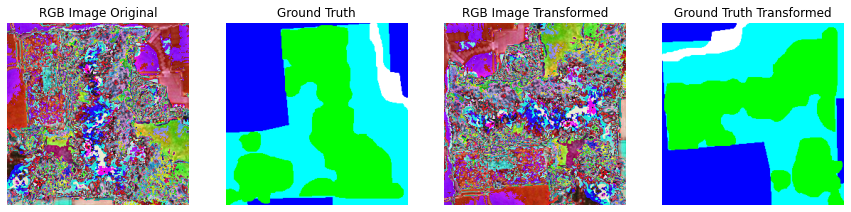

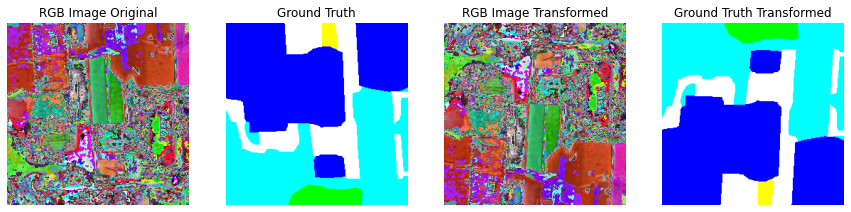

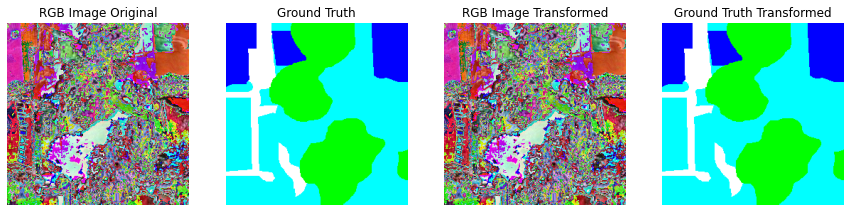

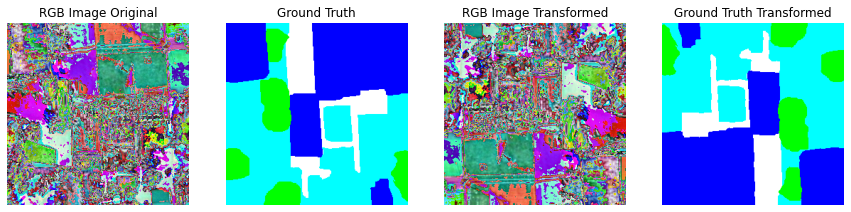

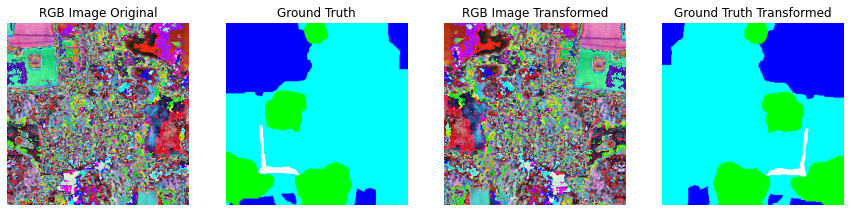

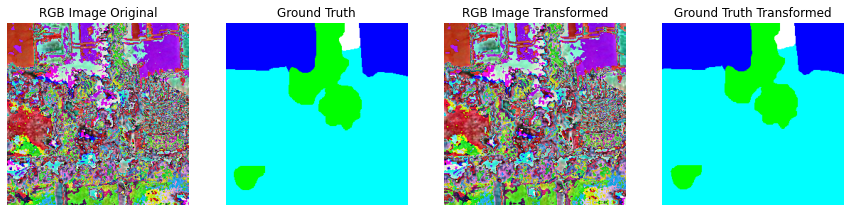

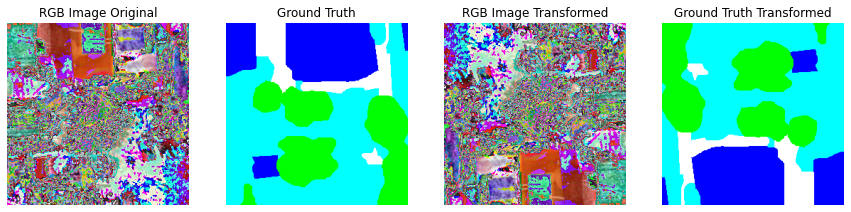

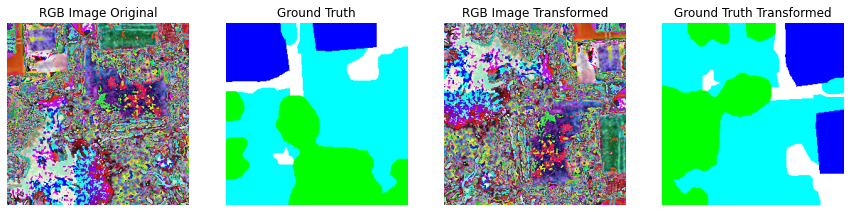

In [ ]:
# Temporal generator without data augmentation
temp_generator = DataGenerator(batch_size=8,
                               patch_size=256,
                               step_size=256,
                               list_top=list_top_train, 
                               list_gts=list_gts_train,
                               list_dsm=list_dsm_train,
                               n_classes=n_classes,
                               colormap_gt=color2index
                               )

# Temporal generator with data augmentation
temp_generator_aug = DataGenerator(batch_size=8,
                                   patch_size=256,
                                   step_size=256,
                                   list_top=list_top_train, 
                                   list_gts=list_gts_train,
                                   list_dsm=list_dsm_train,
                                   n_classes=n_classes,
                                   colormap_gt=color2index,
                                   augmentation=augmentation
                                   )
# Iterate over all batches
for (x,y),(x_aug,y_aug) in zip(temp_generator, temp_generator_aug):  
  # Check the shape of the output of the generator
  print(x.shape, y.shape, x_aug.shape, y_aug.shape)
  for x_i,y_i,x_i_aug,y_i_aug in zip(x,y,x_aug,y_aug):
    # For visualization: [0,1] => [0,255]
    x_i = x_i[:,:,0:3]
    x_i = x_i*255
    x_i_aug = x_i_aug[:,:,0:3]
    x_i_aug = x_i_aug*255
    # Apply argmax to convert from one hot to integers
    y_i = np.argmax(y_i, axis=-1)
    y_i_aug = np.argmax(y_i_aug, axis=-1)
    # Convert each class to a color given a colormap
    y_i_rgb = np.zeros((y_i.shape[0], y_i.shape[1], 3), dtype=np.uint8)
    y_i_aug_rgb = np.zeros((y_i.shape[0], y_i.shape[1], 3), dtype=np.uint8)
    for key,value in color2index.items():
      y_i_rgb[y_i==value] = key
      y_i_aug_rgb[y_i_aug==value] = key
    # Visualization of RGB image and its ground truth or reference
    plt.figure(figsize=(15,10))
    plt.subplot(1,4,1)
    plt.imshow(x_i.astype("uint8"))
    plt.title("RGB Image Original")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(y_i_rgb, cmap="jet")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(x_i_aug.astype("uint8"))
    plt.title("RGB Image Transformed")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(y_i_aug_rgb, cmap="jet")
    plt.title("Ground Truth Transformed")
    plt.axis("off")
    plt.show()
  break

### DataGenerator for train and validation

Let's create the generators for training and validation:
- $batch\_size=8$
- $patch\_size=256$
- $step\_size=256$

In [ ]:
from scipy.sparse import data
batch_size = 8
patch_size = 256
step_size = 256

data_gen_train = DataGenerator(batch_size=batch_size,
                               patch_size=patch_size,
                               step_size=step_size,
                               list_top=list_top_train, 
                               list_gts=list_gts_train,
                               list_dsm=list_dsm_train,
                               n_classes=n_classes,
                               colormap_gt=color2index
                               )

data_gen_train_aug = DataGenerator(batch_size=batch_size,
                                   patch_size=patch_size,
                                   step_size=step_size,
                                   list_top=list_top_train, 
                                   list_gts=list_gts_train,
                                   list_dsm=list_dsm_train,
                                   n_classes=n_classes,
                                   colormap_gt=color2index,
                                   augmentation=augmentation
                                   )

data_gen_val = DataGenerator(batch_size=batch_size,
                             patch_size=patch_size,
                             step_size=step_size,
                             list_top=list_top_val, 
                             list_gts=list_gts_val,
                             list_dsm=list_dsm_val,
                             n_classes=n_classes,
                             colormap_gt=color2index,
                            #  augmentation=augmentation
                             )

data_gen_test = DataGenerator(batch_size=batch_size,
                              patch_size=patch_size,
                              step_size=step_size,
                              list_top=list_top_test, 
                              list_gts=list_gts_test,
                              list_dsm=list_dsm_test,
                              n_classes=n_classes,
                              colormap_gt=color2index
                              )                             

In [ ]:
import torch
mean = float(0)
std = float(0)

# max_list = []
# min_list = []

print('mean type:',type(mean))
print('mean:',mean)
print('std:',std)

for x_train,y_train in data_gen_train_aug:  
  x_train = torch.tensor(x_train)
  mean += torch.mean(x_train,dim=(0,1,2))
  std += torch.std(x_train,dim=(0,1,2) )

  print('mean:',mean)
  print('std:',std)

print('final total mean:',mean)
print('final total std:',std)

print('final mean:',mean/128)
print('final std:',std/128)

mean type: <class 'float'>
mean: 0.0
std: 0.0
mean: tensor([ 0.2208, -0.1816, -0.1481, -2.1230])
std: tensor([1.0616, 0.9142, 0.9221, 0.6547])
mean: tensor([ 0.1634, -0.3589, -0.3365, -4.7057])
std: tensor([2.1120, 1.8005, 1.8206, 1.1616])
mean: tensor([-0.0910, -0.2728, -0.2291, -7.8772])
std: tensor([3.0576, 2.7977, 2.9073, 1.8092])
mean: tensor([ -0.1184,  -0.0686,  -0.1351, -10.7740])
std: tensor([4.0274, 3.8679, 3.9749, 2.6335])
mean: tensor([ -0.2021,   0.0691,   0.1033, -14.5159])
std: tensor([4.9619, 4.8670, 5.1007, 3.2613])
mean: tensor([ -0.3982,   0.2401,   0.3448, -18.2612])
std: tensor([5.8948, 5.8654, 6.2027, 4.1052])
mean: tensor([ -0.4907,   0.3058,   0.3693, -22.2925])
std: tensor([6.8123, 6.7545, 7.0864, 4.8434])
mean: tensor([ -0.4993,   0.1505,   0.1641, -26.3158])
std: tensor([7.8877, 7.6437, 7.9571, 5.6583])
mean: tensor([ -0.6332,   0.1034,   0.0682, -30.5823])
std: tensor([8.8622, 8.4883, 8.8477, 6.4191])
mean: tensor([ -0.5319,   0.1268,  -0.0653, -34.8038])
st

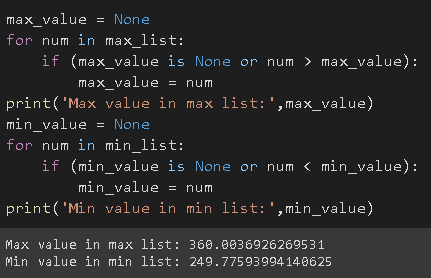

Number of batches in each set:

In [ ]:
print("Train: {}, Validation: {}".format(len(data_gen_train), len(data_gen_val)))

Train: 128, Validation: 38


### U-Net

Functions with block to build a U-Net:
- _conv_block_: convolutional block with only multiple convolutions.
- _downsampling_: downsampling block with a series of convolutions, a max pooling and dropout layers.
- _upsampling_: upsampling block with a transpose convolution, concatenate a feature map, dropout and a series of convolutions.

In [ ]:
def conv_block(x, n_filters, times=2):
  for i in range(times):
    x = Conv2D(filters=n_filters, 
              kernel_size=3, 
              strides=1, 
              padding="same", 
              activation="relu", 
              kernel_initializer="he_normal")(x)
  return x

def downsampling(x, n_filters, times=2):
  feat = conv_block(x, n_filters, times=times)  
  pool = MaxPooling2D(pool_size=2)(feat)
  pool = Dropout(rate=0.3)(pool)
  return feat,pool

def upsampling(input, filters, layer_concat=None):
  x = Conv2DTranspose(filters=filters, 
                      kernel_size=3, 
                      strides=2, 
                      padding="same")(input)
  if layer_concat is not None:
    x = concatenate([x, layer_concat])
  x = Dropout(rate=0.3)(x)  
  x = conv_block(x, filters, times=2)
  return x

Building the U-Net model.

_Notice that the original model has a bottleneck area with **1024** features, we are only using **512** for this example._

In [ ]:
def get_unet(img_size, n_classes):
  # Input
  input = Input(shape=(img_size,img_size,4))
  # Downsampling
  f1,p1 = downsampling(input, 64, times=2)
  f2,p2 = downsampling(p1, 128, times=2)
  f3,p3 = downsampling(p2, 256, times=2)
  # Bottleneck
  blottleneck = conv_block(p3, 512, times=2)
  #Upsampling  
  u7 = upsampling(blottleneck, 256, layer_concat=f3)
  u8 = upsampling(u7, 128, layer_concat=f2)
  u9 = upsampling(u8, 64, layer_concat=f1)
  # Output
  output = Conv2D(filters=n_classes, 
                  kernel_size=1, 
                  padding="same", 
                  activation="softmax")(u9)
  model = Model(inputs=input, outputs=output, name="UNet")

  return model

In [ ]:
model_unet = get_unet(img_size=patch_size, 
                    n_classes=n_classes)

model_unet_focal = get_unet(img_size=patch_size, 
                          n_classes=n_classes)

#### Visualization of DeepLabV3

In [ ]:
model_unet.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

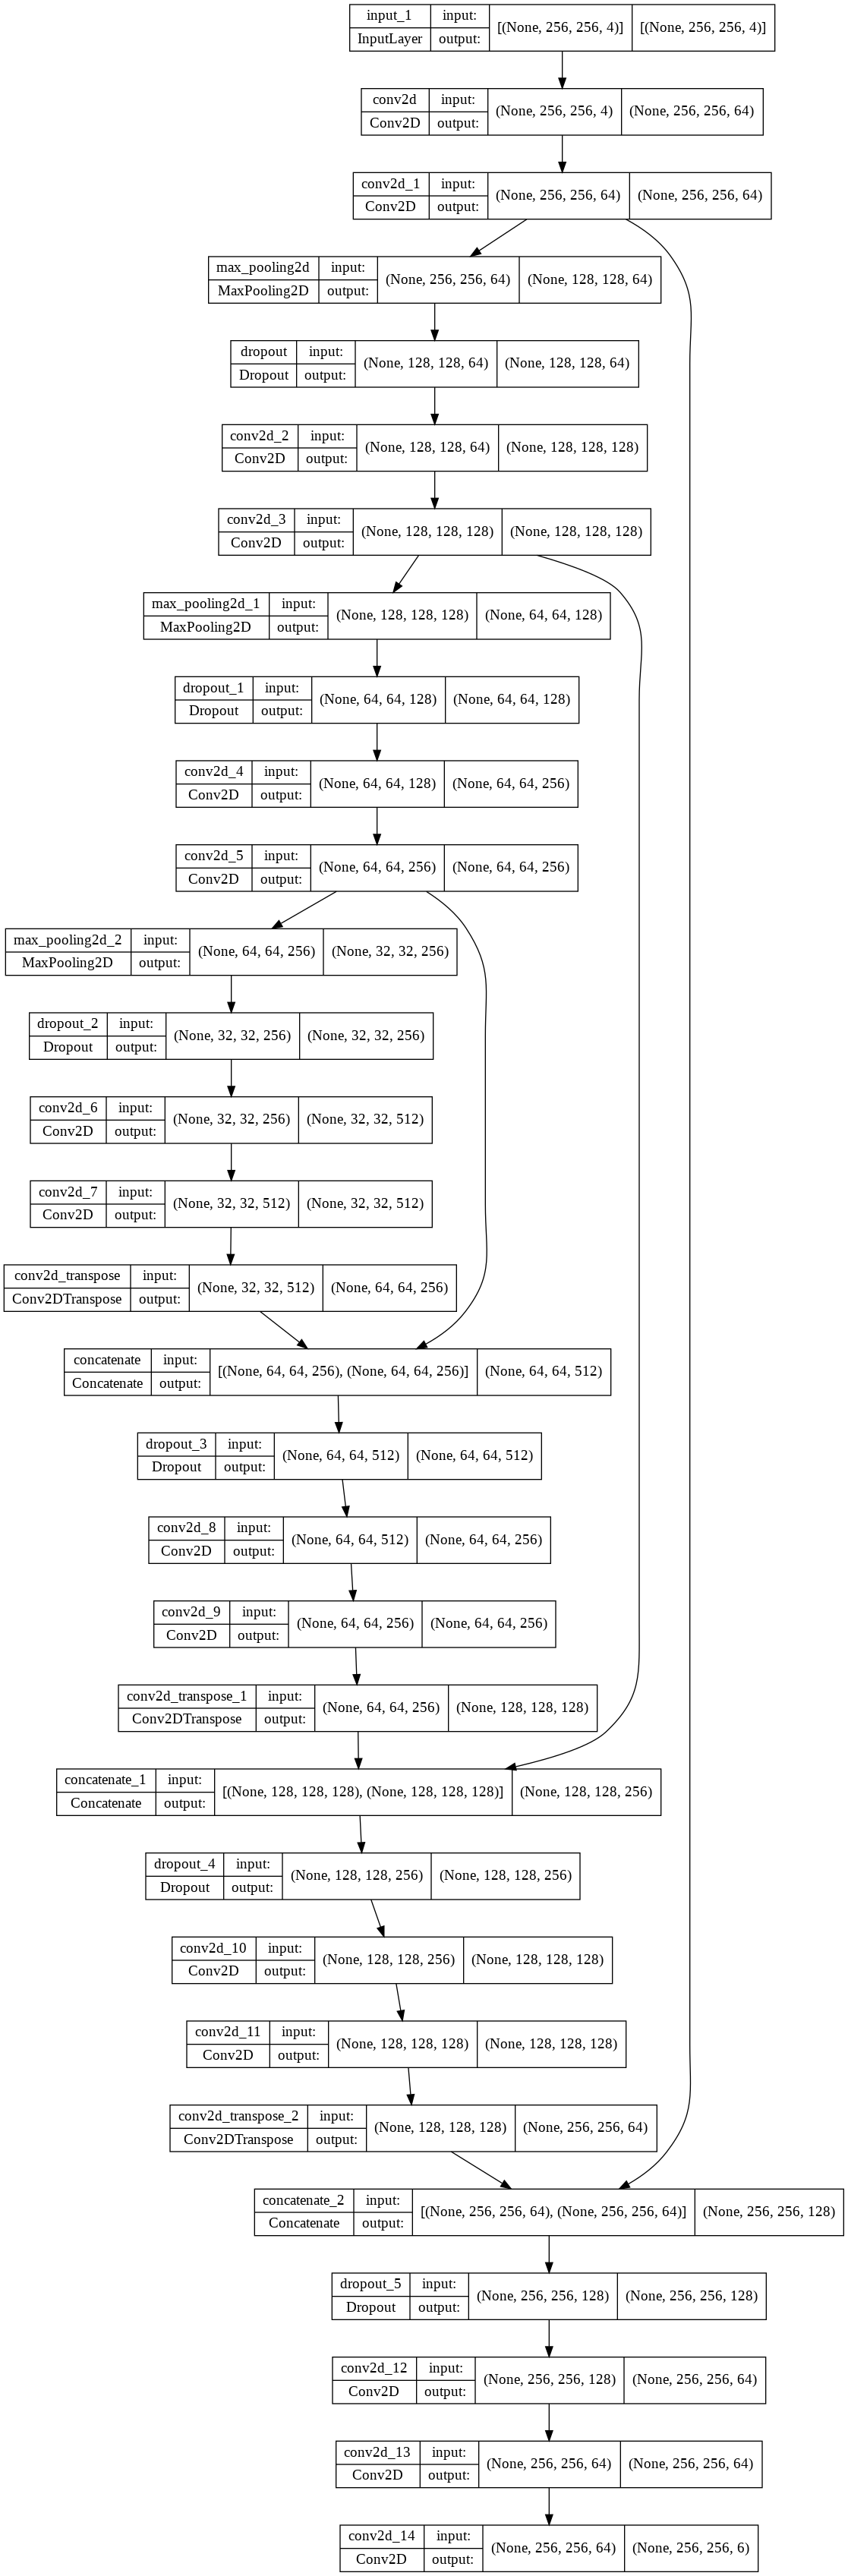

In [ ]:
plot_model(model_unet, to_file="model_unet_with1x1pool.png", show_shapes=True)

## Focal Loss

Let's try focal loss. This is a custom implementation based on this [code](https://raw.githubusercontent.com/aldi-dimara/keras-focal-loss/master/focal_loss.py).

$L_{Focal-Loss}(p_t) = -\alpha(1-p_t)^γlog(p_t) $

where:
- $\alpha_t$: weight to set importance of certain classes.
- $\gamma$: focusing parameter, $\gamma \geq 0$

Thus, this functions has two parameters: $\alpha$ and $\gamma$.

In [ ]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=-1))
        return loss
    
    return focal_loss

## Training configuration

In [ ]:
# U-Net with data augmentation
model_unet.compile(optimizer=Adam(),
                       loss="categorical_crossentropy",
                       metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])
# U-Net with data augmentation, focal loss
model_unet_focal.compile(optimizer=Adam(),
                       loss=categorical_focal_loss(),
                       metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])

## Callbacks

Function to save checkpoints for each model

In [ ]:
def get_ckpt(ckpt_name):
    return ModelCheckpoint(ckpt_name,
                           mode="max", 
                           save_best_only=True, 
                           monitor="val_iou", 
                           verbose=1)

Callbacks definition to be executed during training

In [ ]:
# Checkpoint
autosave_unet_aug = get_ckpt("segmentation_unet.h5")
autosave_unet_aug_focal = get_ckpt("segmentation_unet_focal.h5")

# Early stopping
early_stopping = EarlyStopping(patience=40, verbose=1, mode = 'auto')

# Tensorboard
logdir_unet = join("logs", "unet")
tb_unet = TensorBoard(logdir_unet, histogram_freq=1)

logdir_unet_aug = join("logs", "unet_focal")
tb_unet_aug = TensorBoard(logdir_unet_aug, histogram_freq=1)

# logdir_deeplab = join("logs", "deeplab")
# tb_deeplab = TensorBoard(logdir_deeplab, histogram_freq=1)

# logdir_deeplab_focal = join("logs", "deeplab_focal")
# tb_deeplab_focal = TensorBoard(logdir_deeplab_focal, histogram_freq=1)
# Callbacks
cbks_unet = [autosave_unet_aug, early_stopping, tb_unet]
cbks_unet_aug = [autosave_unet_aug_focal, early_stopping, tb_unet_aug]
# cbks_deeplab = [autosave_deeplab, early_stopping, tb_deeplab]
# cbks_deeplab_focal = [autosave_deeplab_focal, early_stopping, tb_deeplab_focal]

In [ ]:
epochs = 200

## Training

### U-Net with data augmentation

In [ ]:
history_unet = model_unet.fit(data_gen_train_aug,
                              epochs=epochs,                                                     
                              validation_data=data_gen_val,                                                    
                              callbacks=cbks_unet,
                              workers=4, 
                              use_multiprocessing=True,
                              max_queue_size=20
                              )

Epoch 1/200
128/128 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.4964 - iou: 0.2216
Epoch 1: val_iou improved from -inf to 0.23663, saving model to segmentation_unet.h5
128/128 [==============================] - 98s 659ms/step - loss: 1.2446 - accuracy: 0.4964 - iou: 0.2216 - val_loss: 1.2362 - val_accuracy: 0.5100 - val_iou: 0.2366
Epoch 2/200
128/128 [==============================] - ETA: 0s - loss: 0.8582 - accuracy: 0.6372 - iou: 0.3132
Epoch 2: val_iou improved from 0.23663 to 0.27833, saving model to segmentation_unet.h5
128/128 [==============================] - 92s 705ms/step - loss: 0.8582 - accuracy: 0.6372 - iou: 0.3132 - val_loss: 1.0227 - val_accuracy: 0.5819 - val_iou: 0.2783
Epoch 3/200
128/128 [==============================] - ETA: 0s - loss: 0.8037 - accuracy: 0.6710 - iou: 0.3393
Epoch 3: val_iou did not improve from 0.27833
128/128 [==============================] - 92s 702ms/step - loss: 0.8037 - accuracy: 0.6710 - iou: 0.3393 - val_loss

### U-Net with data augmentation and focal loss

In [ ]:
history_unet_aug = model_unet_focal.fit(data_gen_train_aug,
                                      epochs=epochs,                                                     
                                      validation_data=data_gen_val,                                                    
                                      callbacks=cbks_unet_aug,
                                      workers=4, 
                                      use_multiprocessing=True,
                                      max_queue_size=20
                                      )

Epoch 1/200
128/128 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.5687 - iou: 0.2685
Epoch 1: val_iou improved from -inf to 0.30111, saving model to segmentation_unet_focal.h5
128/128 [==============================] - 99s 739ms/step - loss: 0.1305 - accuracy: 0.5687 - iou: 0.2685 - val_loss: 0.1362 - val_accuracy: 0.6175 - val_iou: 0.3011
Epoch 2/200
128/128 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.6403 - iou: 0.3175
Epoch 2: val_iou improved from 0.30111 to 0.30209, saving model to segmentation_unet_focal.h5
128/128 [==============================] - 94s 721ms/step - loss: 0.0937 - accuracy: 0.6403 - iou: 0.3175 - val_loss: 0.1632 - val_accuracy: 0.6085 - val_iou: 0.3021
Epoch 3/200
128/128 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.6803 - iou: 0.3500
Epoch 3: val_iou improved from 0.30209 to 0.31294, saving model to segmentation_unet_focal.h5
128/128 [==============================] - 97s 745ms/ste

### Load trained model


In [ ]:
model_unet.load_weights("segmentation_unet.h5")
model_unet_focal.load_weights("segmentation_unet_focal.h5")

## Model evaluation
Let's compute the metrics and loss function values for the trained models.

In [ ]:
data_gen_test = DataGenerator(batch_size=batch_size,
                              patch_size=patch_size,
                              step_size=step_size,
                              list_top=list_top_test, 
                              list_gts=list_gts_test,
                              list_dsm=list_dsm_test,
                              n_classes=n_classes,
                              colormap_gt=color2index
                              )

print("Train:")
scores_train_unet = model_unet.evaluate(data_gen_train)
scores_train_unet_aug = model_unet_focal.evaluate(data_gen_train)

print("Validation:")
scores_val_unet = model_unet.evaluate(data_gen_val)
scores_val_unet_aug = model_unet_focal.evaluate(data_gen_val)

print("Test:")
scores_test_unet = model_unet.evaluate(data_gen_test)
scores_test_unet_aug = model_unet_focal.evaluate(data_gen_test)

Train:
128/128 [==============================] - 120s 941ms/step - loss: 0.0383 - accuracy: 0.8398 - iou: 0.6207
Validation:
38/38 [==============================] - 33s 879ms/step - loss: 0.1051 - accuracy: 0.8100 - iou: 0.5250
Test:
190/190 [==============================] - 167s 879ms/step - loss: 0.0738 - accuracy: 0.7862 - iou: 0.5120



41.93%
36.38%

## Visualization of the predictions

In [ ]:
def get_mean_iou(y_true, y_pred, n):
  m_iou = OneHotMeanIoU(num_classes=n)
  m_iou.update_state(y_true=y_i, y_pred=y_pred)
  return m_iou.result().numpy()

def get_iou(y_true, y_pred, n, c):
  # Object to compute the IoU for each class
  m_iou_class = OneHotIoU(num_classes=n, 
                          target_class_ids=[c])
  m_iou_class.update_state(y_true=y_true, 
                           y_pred=y_pred)
  # Save IoU for each class
  return m_iou_class.result().numpy()

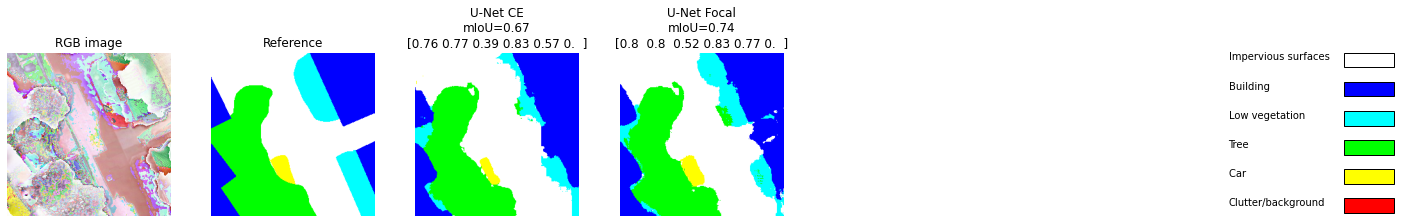

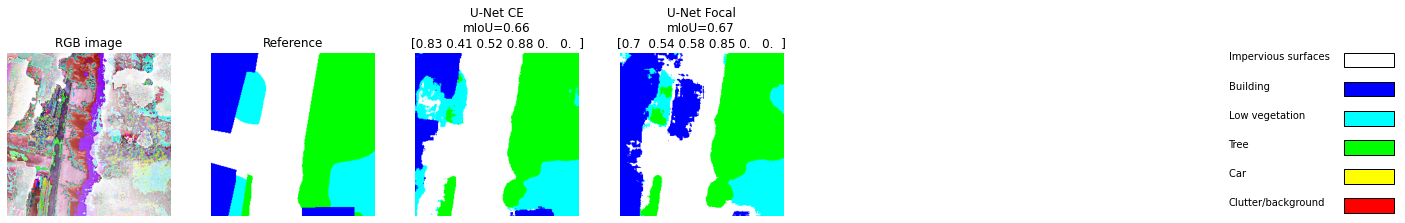

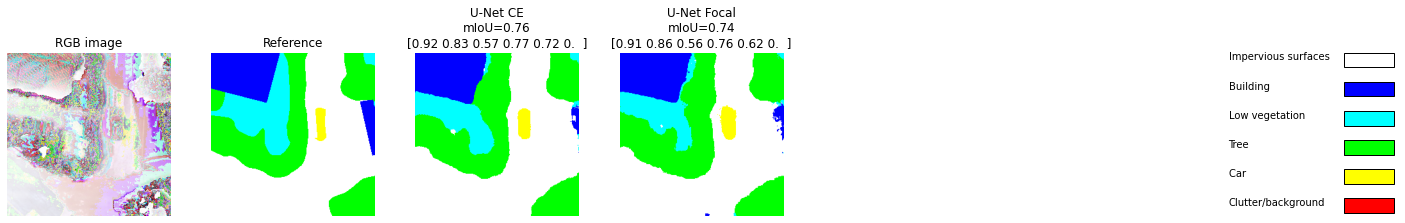

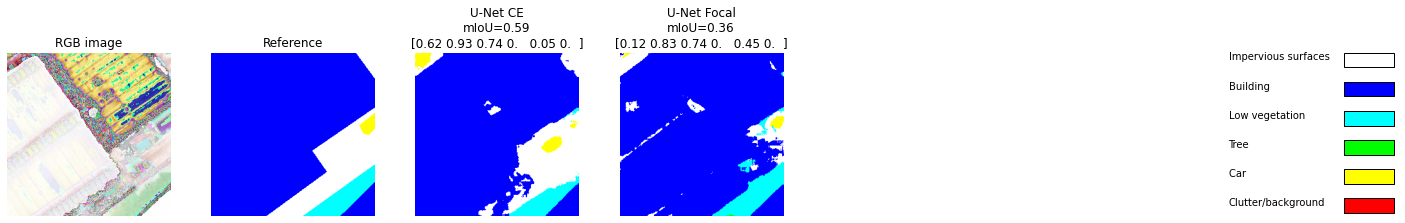

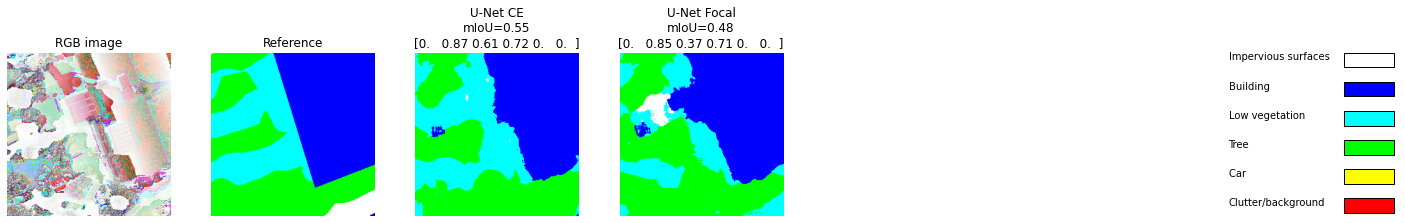

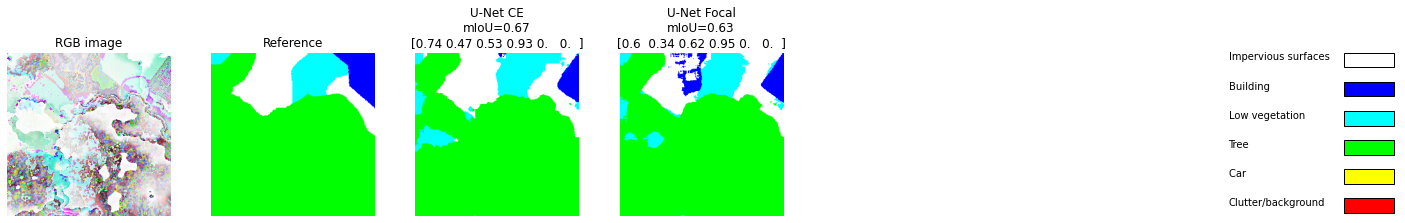

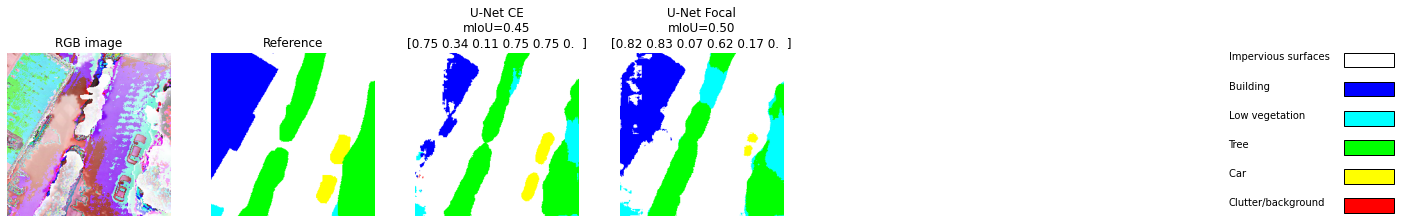

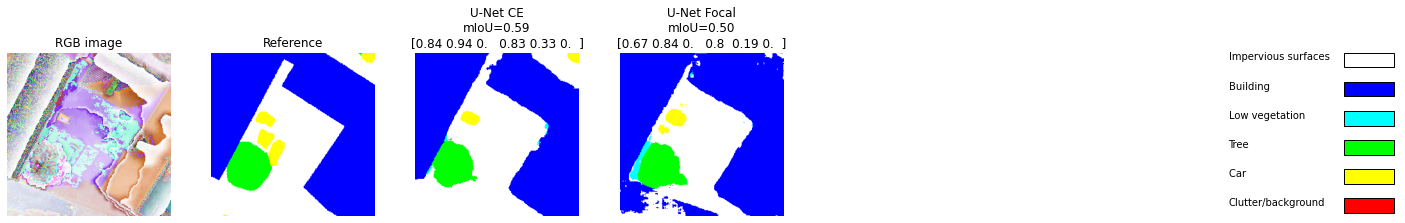

In [ ]:
#@title Predictions Visualization { run: "auto"}
#@markdown Select a sample
id_batch = 160 #@param {type:"slider", min:0, max:189, step:1}

# Get a batch from the generator for testing
x,y = data_gen_test.__getitem__(id_batch)
# Obtain the prediction from the trained models
p_unet = model_unet.predict(x)
p_unet_aug= model_unet_focal.predict(x)

# Iterate over each sample in the batch
for x_i,y_i,p_u_i,p_ua_i in zip(x,y,
                                p_unet,
                                p_unet_aug,
                                ):
  # For visualization: [0,1] => [0,255]
  x_i = x_i*255
  x_i = x_i.astype(np.uint8)
  # From one hot encoding to integer
  gt = np.argmax(y_i, axis=-1)
  p_u = np.argmax(p_u_i, axis=-1)
  p_ua = np.argmax(p_ua_i, axis=-1)

  # Compute the mean IoU
  m_iou_unet = get_mean_iou(y_true=y_i, y_pred=p_u_i, n=n_classes)
  m_iou_unet_aug = get_mean_iou(y_true=y_i, y_pred=p_ua_i, n=n_classes)


  # List to storage IoU per class
  iou_all_unet = []
  iou_all_unet_aug = []
  iou_all_linknet = []
  iou_all_linknet_focal = []
  for id_class in range(n_classes):
    # Save IoU for each class
    iou_all_unet.append(get_iou(y_true=y_i, y_pred=p_u_i,
                                n=n_classes, c=id_class))
    iou_all_unet_aug.append(get_iou(y_true=y_i, y_pred=p_ua_i,
                                    n=n_classes, c=id_class))
  # Color images for the Ground Truth and Prediction
  gt_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  p_u_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  p_ua_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)

  # Assign a color to each integer value from the given dictionary
  for key,value in color2index.items():
    gt_rgb[gt==value] = key
    p_u_rgb[p_u==value] = key
    p_ua_rgb[p_ua==value] = key


  # Visualization
  # Original RGB Image
  plt.figure(figsize=(25,3))
  plt.subplot(1,7,1)
  plt.imshow(x_i)
  plt.title("RGB image")
  plt.axis("off")
  # Ground Truth
  plt.subplot(1,7,2)
  plt.imshow(gt_rgb)
  plt.title("Reference")
  plt.axis("off")
  # Prediction U-Net without Data Augmentation
  plt.subplot(1,7,3)
  plt.imshow(p_u_rgb)
  plt.title("U-Net CE\nmIoU={:.2f}\n{}".format(m_iou_unet,
                                                 np.round(iou_all_unet, decimals=2)))
  plt.axis("off")
  # Prediction U-Net with Data Augmentation
  plt.subplot(1,7,4)
  plt.imshow(p_ua_rgb)
  plt.title("U-Net Focal\nmIoU={:.2f}\n{}".format(m_iou_unet_aug,
                                                 np.round(iou_all_unet_aug, decimals=2)))
  plt.axis("off")
  # Colormap
  g = plt.subplot(1,7,7)
  g.axes.set_xlim(0,3.4)
  g.axes.set_ylim(-0.01,0.55)

  g.text(0, 0.025, "Clutter/background")
  g.text(0, 0.125, "Car ")
  g.text(0, 0.225, "Tree ")
  g.text(0, 0.325, "Low vegetation")
  g.text(0, 0.425, "Building ")
  g.text(0, 0.525, "Impervious surfaces")

  x_rec = 2.3
  g.add_patch(patches.Rectangle((x_rec,0.0), 1, 0.05, facecolor="#FF0000", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.1), 1, 0.05, facecolor="#FFFF00", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.2), 1, 0.05, facecolor="#00FF00", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.3), 1, 0.05, facecolor="#00FFFF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.4), 1, 0.05, facecolor="#0000FF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.5), 1, 0.05, facecolor="#FFFFFF", edgecolor="black"))
  g.axis("off")
  
  plt.show()